# SI608 Final Project
## Predicting bots from reddit comments
Ben Sadis, Jonathan Hartman, Akio Kakishima, Yi Xiao

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [11]:
import math, glob, json

import pandas as pd
import numpy as np
import scipy as sc

import networkx as nx

import seaborn as sns
import matplotlib.pyplot as plt

import sklearn.svm as svm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

## Initial Data Loading

Here is a link to the Google Drive directory where the data is stored:

https://drive.google.com/drive/u/0/folders/1YnVF6bu0awdfZ5zQEOZRr8JB9sxl39kH?ogsrc=32

In order to run this notebook, the data must be downloaded and placed in the same location as the notebook.

In [4]:
user_df = pd.read_csv("user_comments.csv")
user_df.head(2)

,author,created_utc,link_id,parent_id,score,id,subreddit
0,Inshapo,1535781736,t3_9ajgfw,t1_e56nj07,1,e57777s,de
1,haferkeks2,1535790833,t3_9ajgfw,t1_e56ncfy,1,e57bng5,de


In [6]:
print("unique authors:", len(user_df.author.unique()))

unique authors: 630674


Big Query Exported a series of csvs. Merge them together

In [8]:
allFiles = [f for f in glob.glob("bot_comments" + "*.csv") if "text" not in f]
bot_df = pd.DataFrame()
list_ = []
for file_ in allFiles:
    if "1" in file_:
        df = pd.read_csv(file_,index_col = None, header = None)
    else:
        df = pd.read_csv(file_,index_col = None, header = None)
    list_.append(df)
bot_df = pd.concat(list_)
bot_df.columns = ['author', 'created_utc', 'link_id', 'parent_id', 'score', 'id','subreddit']
bot_df = bot_df[bot_df['author'] != "author"]
bot_df.head(2)

,author,created_utc,link_id,parent_id,score,id,subreddit
1,AutoModerator,1540927338,t3_9sr4gj,t3_9sr4gj,1,e8qs619,Twitch_Startup
2,eat-sleep-fortnite,1540927355,t3_9sqje9,t1_e8qrhby,-4,e8qs6tr,unturned


## Build the network

In [13]:
%%time
#if user respond to a same comment, then we linked then together, build the graph
comment_map_user = {} #comment_id, #user_name 
for index, row in user_df.iterrows():
    comment_id = row['id']
    comment_map_user[comment_id] = row['author']

#if bot respond to a same comment, then we linked then together, build the graph
comment_map_bot = {} #comment_id, #user_name 
for index, row in bot_df.iterrows():
    comment_id = row['id']
    comment_map_bot[comment_id] = row['author']
    
network_map = {} # key from user, value {key to user, value counts}
for index, row in user_df.iterrows():
    comment_id = row['id']
    respond_id = row['parent_id'].split("_")[1]
    from_user = comment_map_user[comment_id]
    if respond_id in comment_map_user:
        to_user = comment_map_user[respond_id]
    elif respond_id in comment_map_bot:
        to_user = comment_map_bot[respond_id]
    else:
        continue
    if from_user not in network_map:
        network_map[from_user] = {}
    if to_user not in network_map[from_user]:
        network_map[from_user][to_user] = 0
    network_map[from_user][to_user] += 1
    
for index, row in bot_df.iterrows():
    comment_id = row['id']
    respond_id = row['parent_id'].split("_")[1]
    from_user = comment_map_bot[comment_id]
    if respond_id in comment_map_user:
        to_user = comment_map_user[respond_id]
    elif respond_id in comment_map_bot:
        to_user = comment_map_bot[respond_id]
    else:
        continue
    if from_user not in network_map:
        network_map[from_user] = {}
    if to_user not in network_map[from_user]:
        network_map[from_user][to_user] = 0
    network_map[from_user][to_user] += 1

Wall time: 22min 26s


In [14]:
# save the network to a json file so we only have to build it once
with open('network.json', 'w') as fp:
    json.dump(network_map, fp)

In [15]:
# load the network file
with open("network.json") as f_in:
    network_map = json.load(f_in)

Load the network into NetworkX

In [16]:
g = nx.DiGraph()
for key, value in network_map.items():
    from_user = key
    for k, v in value.items():
        to_user = k
        weight = v
        g.add_edge(from_user, to_user, weight = weight)

## Network Feature Extraction

### Get Overall Graph Statistics

In [18]:
%%time
# pull these up now so we can just pull nodes from them as we get them
g_degree_centrality = nx.degree_centrality(g)
g_in_degree_centrality = nx.in_degree_centrality(g)
g_out_degree_centrality = nx.out_degree_centrality(g)
g_avg_neighbor_degree = nx.average_neighbor_degree(g)
g_pagerank = nx.pagerank(g)

Wall time: 39.5 s


### Function to Get Individual Node Measures

In [19]:
def get_node_stats(node, triads=False):
    r = {}
    r['degree'] = g.degree[node]
    
    # get the ego graph for this node
    radius = 3
    if r['degree'] > 200:
        radius = 2
    ego = nx.ego_graph(g, node, radius=radius)
    
    # save this node's name
    r['node'] = node
    
    r['avg_clustering'] = nx.average_clustering(nx.Graph(ego))
    r['ego_density'] = nx.density(ego)
    
    # edge measures
    r['avg_neighbor_degree'] = g_avg_neighbor_degree[node]
    in_edges = g.in_edges(node, data=True)
    out_edges = g.out_edges(node, data=True)
    r['in_degree'] = len(in_edges)
    r['out_degree'] = len(out_edges)
    r['sum_in_edge_weight'] = sum([edge[2]['weight'] for edge in in_edges])
    r['sum_out_edge_weight'] = sum([edge[2]['weight'] for edge in out_edges])
    r['avg_in_edge_weight'] = np.mean([edge[2]['weight'] for edge in in_edges])
    r['avg_out_edge_weight'] = np.mean([edge[2]['weight'] for edge in out_edges])
    
    if len(ego) > 1:
        r['reciprocity'] = nx.reciprocity(nx.ego_graph(g, node))
    else:
        r['reciprocity'] = 0
    
    # centrality
    r['degree_centrality'] = g_degree_centrality[node]
    r['in_degree_centrality'] = g_in_degree_centrality[node]
    r['out_degree_centrality'] = g_out_degree_centrality[node]
    
    r['pagerank'] = g_pagerank[node]
    
    if not triads:
        return r
    
    # get just this user and it's neighbors
    ego = nx.ego_graph(g, node, radius=1)
    
    # triad counts/ratios
    triads = nx.triadic_census(ego)
    s = max(sum(triads.values()),1)
    triad_ratios = {str(k)+"_ratio":v/s for (k,v) in triads.items()}
    
    return {**r, **triads, **triad_ratios}

In [23]:
# combine them in a single df
combined_df = pd.concat([bot_df,user_df])

,author,created_utc,link_id,parent_id,score,id,subreddit
307713,AutoModerator,1540896762,t3_9smqop,t3_9smqop,2,e8puw89,hentai_irl
379177,AutoModerator,1538576194,t3_9l1jwq,t3_9l1jwq,1,e73a57f,unpopularopinion
129578,xfile345,1540761344,t3_9s52uy,t1_e8milzk,1,e8minjh,NASCAR
390549,_KanyeWest_,1538479262,t3_9ko7q4,t1_e70q3qc,69,e70szrf,xboxone
154745,AutoModerator,1539907260,t3_9peo05,t3_9peo05,2,e815q1t,DestinyFashion


In [24]:
filename = "node_measures.csv"

# In case we had to stop partway, load what we banked so we can avoid calculating those nodes again
try:
    already_calc = pd.read_csv(filename)
    already_calc.set_index('node', inplace=True)
except:
    print("Can't find a file named",filename)
    already_calc = pd.DataFrame()

### Iterate through all the unique user names and calculate their network statistics

In [ ]:
%%time
# get a list of all the bot usernames
bot_list = bot_df.author.unique()

total_count = len(combined_df.author.unique())
count = 0
results = []
start = time.time()
not_skipping = False
for user in combined_df.author.unique():
    try:
        if not user in already_calc.index:
            results.append({
                **get_node_stats(user, triads=True),
                **{'bot':(0,1)[user in bot_list]}
            })
            not_skipping = True
        count += 1
    except Exception as e:
#         print("Exception: node {}: {}".format(user, e))
        pass
    
    if count % 10000 == 0 and not_skipping:
        print("{} of {} ({:.4f} s/row)".format(count, total_count, (time.time()-start)/10000))
        start = time.time()
        
        if os.path.isfile(filename):
            pd.DataFrame(results).to_csv(filename, mode='a', header=False, index=None)
        else:
            pd.DataFrame(results).to_csv(filename, index=None)
        
        results = []
        

## Text Feature Extraction

Load in the Comment Data Sets

In [25]:
bot_comments = pd.read_csv("bot_comments_text.csv")
bot_comments['is_bot'] = 1
bot_comments.sample(3)

,body,author,created_utc,link_id,parent_id,score,id,subreddit,is_bot
159596,**PLEASE READ THIS MESSAGE IN ITS ENTIRETY BEF...,AutoModerator,1540794692,t3_9saps3,t3_9saps3,1,e8nez4z,AskReddit,1
191309,*Image Transcription: Reddit*\n\n---\n\n&gt;**...,Vinccool96,1540498494,t3_9rdfx1,t3_9rdfx1,1,e8g3q72,iamverybadass,1
8312,**Direct link**: https://www.chron.com/sports/...,amp-is-watching-you,1539016494,t3_9mc959,t1_e7ee2sa,2,e7ee43r,HumansBeingBros,1


In [26]:
user_comments = pd.read_csv("user_comments_text.csv")
user_comments['is_bot'] = 0
user_comments.sample(3)

,body,author,created_utc,link_id,parent_id,score,id,subreddit,is_bot
671085,don't you think its a coincidence there are 3 ...,Spirit_43,1540890632,t3_9sm5bd,t3_9sm5bd,3,e8prv9r,Showerthoughts,0
67291,Ditto.,Celtic_Crown,1539311126,t3_9ng16e,t1_e7m1jsr,3,e7m48gv,RWBY,0
681760,"Considering the economic embargo placed on it,...",Dissidentt,1539624024,t3_9nnonv,t1_e7t9t0q,1,e7tgkib,canada,0


Merge the data sets

In [27]:
combined_comments = pd.concat([user_comments, bot_comments])

Remove anything incorrectly tagged as a bot after a manual curation of the dataset

*(Each member ran 'bot_labelling.py' individually)*

In [28]:
manual_labels = pd.concat([
    pd.read_csv("jon_results.csv"),
    pd.read_csv("ben_results.csv"),
    pd.read_csv("akio_results.csv"),
    pd.read_csv("yi_results.csv"),
])

combined_comments.loc[
    ~combined_comments.author.isin(
        manual_labels[manual_labels.label.notnull()].user.values
    ), 'is_bot'] = 0

## Calculate Per Comment Features

In [29]:
# convert the time_posted column to a datetime
combined_comments['time_posted'] = pd.to_datetime(combined_comments.created_utc, unit='s')
# extract the hour and minute from the time_posted
combined_comments['hour'] = combined_comments.time_posted.dt.hour
combined_comments['minute'] = combined_comments.time_posted.dt.minute
# get the number of words in each
combined_comments['num_words'] = combined_comments.body.apply(str).apply(str.split).apply(len)

In [88]:
combined_comments.sample(3)

,body,author,created_utc,link_id,parent_id,score,id,subreddit,is_bot,time_posted,hour,minute,num_words
157095,\n*300 MemeCoins invested @ 84 upvotes*\n\nUPD...,MemeInvestor_bot,1539376963,t3_9nnf39,t1_e7nor7a,1,e7nornu,MemeEconomy,1,2018-10-12 20:42:43,20,42,33
260772,Sad day for JRPGs,sunjay140,1540240295,t3_9qhfqa,t3_9qhfqa,-47,e899gwx,JRPG,0,2018-10-22 20:31:35,20,31,4
728305,"""I'm doing it for teh children!"" Don't believe...",Drunken_Pineapple,1539367154,t3_9nillj,t1_e7ncx2t,5,e7nd95e,antiMLM,0,2018-10-12 17:59:14,17,59,21


## Aggregate comment features by user

In [31]:
%%time
# group the fields we just calculated by author
by_user = pd.concat(
    [
        combined_comments.groupby('author').size(),
        combined_comments.groupby('author').score.mean(),
        combined_comments.groupby('author').minute.std(),
        combined_comments.groupby('author').num_words.std(),
        combined_comments.groupby('author').subreddit.nunique(),
        combined_comments.groupby('author').is_bot.max()
    ]
, axis=1)
# rename the columns to reflect the aggregate operations
by_user.columns = ['num_comments','mean_score', 'std_minute', 'std_num_words', 'num_unique_subs', 'is_bot']
# calculated new columns based on aggregated columns
by_user['unique_subs_per_comment'] = by_user.num_unique_subs / by_user.num_comments

Wall time: 4.22 s


In [32]:
by_user.sample(3)

,num_comments,mean_score,std_minute,std_num_words,num_unique_subs,is_bot,unique_subs_per_comment
author,,,,,,,
PM_nudes4_rating_pls,70,5.085714,18.822198,4.931917,26,0,0.371429
GhostBruh420,66,10.484848,16.656631,44.703918,7,0,0.106061
brandonsmash,71,1.957746,17.410131,53.680765,6,0,0.084507


Text(0.5,1,'Standard Deviation of Minute Posted - Users vs Bots')

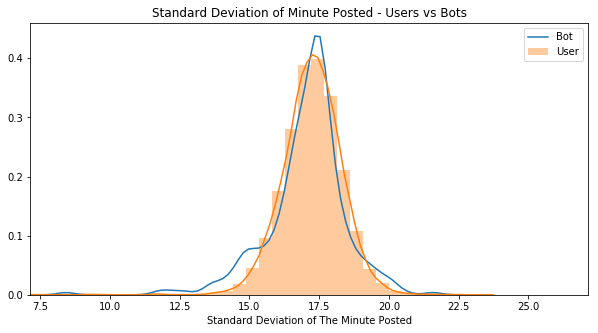

In [33]:
fig, ax = plt.subplots(figsize=(10, 5))

sns.distplot(by_user.query("num_comments > 15 & is_bot == 1").std_minute, ax=ax, label="Bot", hist=False)
sns.distplot(by_user.query("num_comments > 15 & is_bot == 0").std_minute, ax=ax, label="User")

x_mean = by_user.std_minute.mean()
plt.xlim((x_mean-10, x_mean+10))

plt.xlabel("Standard Deviation of The Minute Posted")

ax.legend()
plt.title("Standard Deviation of Minute Posted - Users vs Bots")

## Machine Learning

Load in the network measures we calculated using the get_network_feats notebook

In [60]:
%%time
network_measures = pd.read_csv("node_measures.csv")
network_measures.set_index("node", inplace=True)

# these measures are causing issues
network_measures.drop(['avg_in_edge_weight', 'avg_out_edge_weight', 'bot'], axis=1, inplace=True)
# drop the triad counts - they don't seem to be relevant to anything
network_measures.drop([c for c in network_measures.columns[:32] if "ratio" not in c], axis=1, inplace=True)

Wall time: 4.18 s


In [96]:
network_measures.sample(2)

,003_ratio,012_ratio,021C_ratio,021D_ratio,021U_ratio,030C_ratio,030T_ratio,102_ratio,111D_ratio,111U_ratio,...,degree_centrality,ego_density,in_degree,in_degree_centrality,out_degree,out_degree_centrality,pagerank,reciprocity,sum_in_edge_weight,sum_out_edge_weight
node,,,,,,,,,,,,,,,,,,,,,
Sailans,0.000000,0.0,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000005,0.044828,0,0.000000,2,0.000005,6.421734e-07,0.000000,0,2
TheOGB8ter,0.666667,0.0,0.0,0.178571,0.0,0.0,0.0,0.0,0.0,0.142857,...,0.000039,0.004563,8,0.000018,9,0.000021,4.439253e-06,0.333333,14,11


Merge the text measures and the network measures into a single dataframe

In [69]:
data = pd.merge(by_user, 
                network_measures, 
                left_index=True, right_index=True)

# only use users with sufficient data
data = data.query("num_comments >= 15")

# remove any duplicate information we collected somehow (affects 42 rows)
data = data[data.index.isin(data.index.drop_duplicates())].copy()

# save the bot labels and column names so we can get them back after the scalar
bot_labels = data.is_bot
cols = data.columns

# run a scalar on the data
scaler = StandardScaler()
data = pd.DataFrame(
    scaler.fit_transform(data), 
    index=data.index,
    columns=cols
)
# reassign the bot labels
data.is_bot = bot_labels

## Hyperparameter Testing Functions

In [37]:
# data (REQUIRED) is dataset that includes all columns and labels
# column_list is list of columns to use as features
# - if all columns are desired don't pass in a parameter
# label_column (REQUIRED) is the column in the dataset that is the labels
# num_runs is the number of times to run each parameter setting
def run_SVC(data = [], column_list=[], label_column='', num_runs=10, verbose=False):
    if len(data) == 0 or label_column == '':
        print("You need to give me a dataset and a label column name")
        return
    if len(column_list) == 0:
        column_list = data.columns[data.columns != label_column]
    Cs = [1, 3, 5, 7]
    gammas = [0.001, 0.0001, 0.0003, 0.0007, 0.0005]
    C_array = []
    gamma_array = []
    sens_array = []
    spec_array = []
    for i in range(num_runs):
        if verbose: print("i: " + str(i))
        train, test = train_test_split(data, test_size = 0.3)
        for C in Cs:
            for gamma in gammas:
                if verbose: print("C: " + str(C))
                if verbose: print("gamma: " + str(gamma))
                clf = svm.SVC(kernel='linear', class_weight='balanced', C=C, gamma=gamma)
                clf.fit(train.loc[:,column_list], train[label_column])
                pred = clf.predict(test.loc[:,column_list])
                labels = pd.DataFrame(test[label_column])
                labels["pred"] = pred
                sens = len(labels.query("is_bot == 1 and pred == 1")) / len(labels.query("is_bot == 1"))
                spec = len(labels.query("is_bot == 0 and pred == 0")) / len(labels.query("is_bot == 0"))
                if verbose: print(sens)
                if verbose: print(spec)
                C_array.append(C)
                gamma_array.append(gamma)
                sens_array.append(sens)
                spec_array.append(spec)
    row_dict = {'C': C_array, 'gamma': gamma_array, 'sens': sens_array, 'spec': spec_array}
    row_df = pd.DataFrame(row_dict)
    row_df['acc'] = (row_df.sens + row_df.spec) / 2
    row_df = row_df.groupby(['C', 'gamma'], as_index=True).agg('mean')
    return(row_df)

In [38]:
# data (REQUIRED) is dataset that includes all columns and labels
# column_list is list of columns to use as features
# - if all columns are desired don't pass in a parameter
# label_column (REQUIRED) is the column in the dataset that is the labels
# num_runs is the number of times to run each parameter setting
def run_rf(data = [], column_list=[], label_column='', num_runs=10, verbose=False):
    if len(data) == 0 or label_column == '':
        print("You need to give me a dataset and a label column name")
        return
    if len(column_list) == 0:
        column_list = data.columns[data.columns != label_column]
    num_features = len(column_list)
    trees = [2, 10, 100]
    n_feats = [math.ceil(num_features / 10), math.ceil(num_features / 5), 
               math.ceil(num_features / 2), math.ceil(num_features / 1)]
    tree_array = []
    feat_array = []
    sens_array = []
    spec_array = []
    for i in range(num_runs):
        if verbose: print("i: " + str(i))
        train, test = train_test_split(data, test_size = 0.3)
        for tree in trees:
            for feat in n_feats:
                if verbose: print("trees: " + str(tree))
                if verbose: print("n_feats: " + str(feat))
                clf = RandomForestClassifier(class_weight='balanced', n_estimators=tree, max_features=feat)
                clf.fit(train.loc[:,column_list], train[label_column])
                pred = clf.predict(test.loc[:,column_list])
                labels = pd.DataFrame(test[label_column])
                labels["pred"] = pred
                sens = len(labels.query("is_bot == 1 and pred == 1")) / len(labels.query("is_bot == 1"))
                spec = len(labels.query("is_bot == 0 and pred == 0")) / len(labels.query("is_bot == 0"))
                if verbose: print(sens)
                if verbose: print(spec)
                tree_array.append(tree)
                feat_array.append(feat)
                sens_array.append(sens)
                spec_array.append(spec)
    row_dict = {'trees': tree_array, 'n_feats': feat_array, 'sens': sens_array, 'spec': spec_array}
    row_df = pd.DataFrame(row_dict)
    row_df['acc'] = (row_df.sens + row_df.spec) / 2
    row_df = row_df.groupby(['trees', 'n_feats'], as_index=True).agg('mean')
    return(row_df)

### SVC Testing for text only features, network only features, and combined features

In [ ]:
%%time
run_SVC(
    data = data, 
    column_list = ['num_comments', 'mean_score', 'std_minute', 'std_num_words','num_unique_subs', 'unique_subs_per_comment'],
    label_column = 'is_bot', 
    num_runs = 100).to_csv("svc_results_text.csv")

In [ ]:
%%time
run_SVC(
    data = data, 
    column_list = network_measures.columns.values,
    label_column = 'is_bot', 
    num_runs = 100).to_csv("svc_results_network.csv")

In [ ]:
%%time
run_SVC(
    data = data, 
    label_column = 'is_bot', 
    num_runs = 100).to_csv("svc_results_combined.csv")

### Random Forest Testing for text only features, network only features, and combined features

In [ ]:
%%time
run_rf(
    data = data, 
    column_list = ['num_comments', 'mean_score', 'std_minute', 'std_num_words','num_unique_subs', 'unique_subs_per_comment'],
    label_column = 'is_bot', 
    num_runs = 100).to_csv("rf_results_text.csv")

In [ ]:
%%time
run_rf(
    data = data, 
    column_list = network_measures.columns.values,
    label_column = 'is_bot', 
    num_runs = 100).to_csv("rf_results_network.csv")

In [ ]:
%%time
run_rf(
    data = data, 
    label_column = 'is_bot', 
    num_runs = 100).to_csv("rf_results_combined.csv")

## Find the most important features using a random forest classifier

In [81]:
def find_important(data):
    # split the data into training and test sets
    train, test = train_test_split(data, test_size = 0.3)

    # identify the label column and the feature columns
    label_column = 'is_bot'
    column_list = [x for x in data.columns if x not in [label_column]]

    # run the classifier
    clf = RandomForestClassifier(class_weight='balanced', n_estimators=100, max_features=35)
    clf.fit(train.loc[:,column_list], train[label_column])
    
    return clf.feature_importances_

In [ ]:
%%time
results = []
for x in range(10):
    results.append(find_important(data))

In [ ]:
pd.DataFrame(results, columns=[x for x in data.columns if x not in ['is_bot']]).mean().sort_values(ascending=False).head(20)